In [ ]:
# default_exp data.las

# Las

> Basic functionalities to work and process point cloud (LAS/LAZ) files

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product 

In [ ]:
#hide
from pathlib import Path
import os
import random
import re
from fastcore.test import *

# Opening and plotting point clouds

In [ ]:
data_path = Path('data/')
example = '914153.las'

plot_x = 365188.3
plot_y = 6943847.83

`laspy` is used for opening las-files.

In [ ]:
data = laspy.file.File(data_path/example, mode='r')

Point clouds have the following features for each point.

In [ ]:
for spec in data.point_format: print(spec.name)

X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time


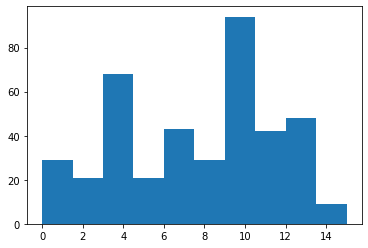

In [ ]:
intensities = np.array([p[0][3] for p in data.points])
plt.hist(intensities, bins='auto')
plt.show()

In [ ]:
# export
def plot_point_cloud(lasfile:laspy.file.File, **kwargs) -> plt.Axes:
    "Return 3d-projection of point cloud"
    points = lasfile.points.copy()
    las_scaleX = lasfile.header.scale[0]
    las_scaleY = lasfile.header.scale[1]
    las_scaleZ = lasfile.header.scale[2]
    las_offsetX = lasfile.header.offset[0]
    las_offsetY = lasfile.header.offset[1]
    las_offsetZ = lasfile.header.offset[2]

    p_X = np.array((points['point']['X'] * las_scaleX) + las_offsetX)
    p_Y = np.array((points['point']['Y'] * las_scaleY) + las_offsetY)
    p_Z = np.array((points['point']['Z'] * las_scaleZ) + las_offsetZ)

    fig = plt.figure(figsize=(10,10), **kwargs)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(p_X, p_Y, p_Z, c='r', marker='o')
    return ax

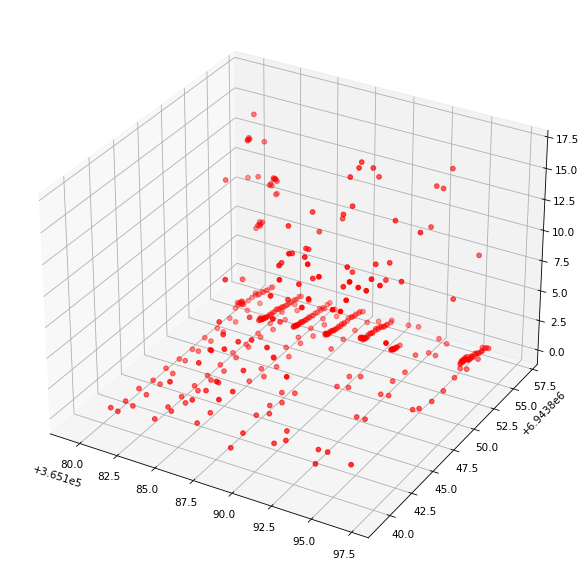

In [ ]:
plot_point_cloud(data, dpi=75)
plt.show()

In [ ]:
# export
def plot_2d_views(lasfile:laspy.file.File)-> plt.Axes:
    "Return X-Y, X-Z and Y-Z -views from lasfile"
    points = lasfile.points.copy()
    las_scaleX = lasfile.header.scale[0]
    las_scaleY = lasfile.header.scale[1]
    las_scaleZ = lasfile.header.scale[2]
    las_offsetX = lasfile.header.offset[0]
    las_offsetY = lasfile.header.offset[1]
    las_offsetZ = lasfile.header.offset[2]

    p_X = np.array((points['point']['X'] * las_scaleX) + las_offsetX)
    p_Y = np.array((points['point']['Y'] * las_scaleY) + las_offsetY)
    p_Z = np.array((points['point']['Z'] * las_scaleZ) + las_offsetZ)
    fig, axs = plt.subplots(1,3, figsize=(13,4))
    axs[0].scatter(p_X, p_Y)
    axs[0].grid()
    axs[0].set_title('X=lon, Y=lat')
    axs[1].scatter(p_X, p_Z)
    axs[1].grid()
    axs[1].set_title('X=lon, Y=height')
    axs[2].scatter(p_Y, p_Z)
    axs[2].grid()
    axs[2].set_title('X=lat, Y=height')
    return axs

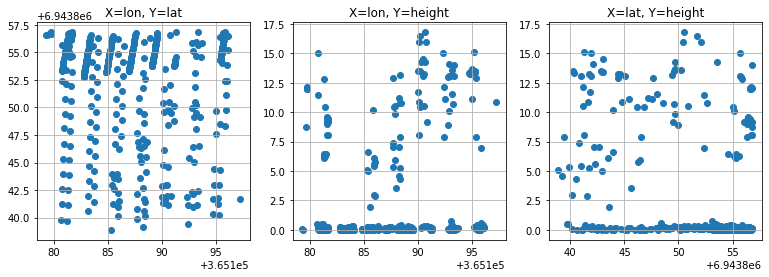

In [ ]:
plot_2d_views(data)
plt.show()

There are other views that can be used, like those presented in [Hamraz(2019)](https://www.sciencedirect.com/science/article/pii/S0924271619302485). 

First, the DSM x 4 -format, where the point cloud is pinned to a square horizontal grid, and for each pixel the following values are recorded:
1. Elevation above ground of the highest leaf-on point
2. Normalized intensity of the highest leaf-on point
3. Elevation above ground of the highest leaf-off point 
4. Normalized intensity of the highest leaf-off point

Our data does not contain enough information for this, unfortunately.

# LiDAR data in tabular format

Opening and calculating field plot -specific features from a point cloud file. 

TODO add metrics from lidR [`stdmetrics`](https://github.com/Jean-Romain/lidR/wiki/stdmetrics) here.

In [ ]:
#export

def las_to_df(fn:str) -> pd.DataFrame:
    """Open .las-file and return it as dataframe with columns [x, y, z, num_returns, intensity].
    Also convert point cloud to photogrammetric, meaning only one z-coordinate in each x-y -pair"""
    lasfile = laspy.file.File(fn, mode='r')
    lidar_df = pd.DataFrame(columns=['x', 'y', 'z', 'num_returns', 'intensity'],
                            data=np.dstack((lasfile.x, lasfile.y, lasfile.z, lasfile.num_returns, lasfile.intensity))[0])
    # Make sure we only have one value for each x,y -point (photogrammetric point cloud)
    lidar_df = lidar_df.drop_duplicates(['x','y'], keep='last')
    lasfile.close()
    return lidar_df

def mask_plot_from_lidar(lidar_df:pd.DataFrame, plot_x:float, plot_y:float, radius:float=9) -> pd.DataFrame:
    "Select only the circular field plot area as used lidar data, center point of plot is <plot_x, plot_y>"
    lidar_df = lidar_df[lidar_df.apply(lambda row:np.linalg.norm(np.array([row.x, row.y]).T - np.array([plot_x, plot_y]).T) <= 9, axis=1)]
    return lidar_df              

In [ ]:
example_df = las_to_df(data_path/example)
test_eq(type(example_df), pd.DataFrame)
print(example_df.shape)
      
example_df = mask_plot_from_lidar(example_df, plot_x,plot_y)
test_eq(type(example_df), pd.DataFrame)
print(example_df.shape)

(402, 5)
(286, 5)


Features calculated are adapted from (Næsset [2004](http://dx.doi.org/10.1080/02827580310019257); Packalén and Maltamo 2006, [2008](http://dx.doi.org/10.1139/X08-037)), as well as other potentially usable.

The most basic features are height based and intensity based features:

In [ ]:
# exports

height_cols = ['hmax', 'hmean', 'hstd', 'cv']

def calc_height_features(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    """Calculate height based features from dataframe from vegetation points (points with z-coordinate above `min_h`).
    Returns a list with maximum height, mean height, standard deviation for height and coefficient of variation for height
    """
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    
    hmax = vege_df.z.max() # maximum height
    hmean = vege_df.z.mean() # mean height
    hstd  = vege_df.z.std() # standard deviation for height
    cv = hstd / hmean # coefficient of variation
    
    h_features = [hmax, hmean, hstd, cv]
    return h_features

intensity_cols = ['imax', 'imean', 'imedian']

def calc_intensity_features(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    """Calculate intensity based features from vegetation points (points with z-coordinate above `min_h`).
    Returns a list with maximum intensity, mean intensity and median intensity
    """
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    imax = vege_df.intensity.max() # maximum intensity
    imean = vege_df.intensity.mean() # mean intensity
    imedian = vege_df.intensity.median() # median intensity
    
    intensity_features = [imax, imean, imedian]  
    return intensity_features

In [ ]:
example_height = calc_height_features(example_df)
test_eq(type(example_height), list)
assert(len(example_height) == len(height_cols))
example_height

[16.785, 10.236584615384617, 3.778763305849497, 0.36914297569233917]

In [ ]:
example_intensity = calc_intensity_features(example_df)
test_eq(type(example_intensity), list)
assert(len(example_intensity) == len(intensity_cols))
example_intensity

[9.0, 3.6615384615384614, 3.0]

Also get the levels H00, H05,..., H90, H95, where corresponding percentages of vegetation points were accumulated.

In [ ]:
# exports

quantile_cols = [f'h{int(q):02d}' for q in np.linspace(0,95, 20)] # last quantile is the same as hmax

def calc_height_quantiles(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    "Calculate height quantiles for 5% intervals, feature 3"
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    quantiles = [vege_df.z.quantile(q) for q in np.linspace(0,.95,20)]
    return quantiles

In [ ]:
example_quantiles = calc_height_quantiles(example_df)
test_eq(type(example_quantiles), list)
assert(len(example_quantiles) == len(quantile_cols))
example_quantiles[-5:]

[13.213000000000001, 13.424600000000002, 13.6326, 14.2442, 15.740599999999997]

Next get the proportion of vetgetation points with H greater or equal to corresponding percentile of H, as well as proportion of vegetation points and veg/ground ratio.

In [ ]:
# exports

point_cols = ['veg', 'veg_ground_ratio']
proportion_cols = [f'p{int(q):02d}' for q in np.linspace(0.05,95, 19)]

def calc_point_proportions(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    "Calculate point proportions for points above quantiles H05, H10,..., H90, H95"
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    quantiles = [vege_df.z.quantile(q) for q in np.linspace(0.05,.95,19)]
    proportions = [len(vege_df[vege_df.z >= q])/len(vege_df) for q in quantiles]
    return proportions

def calc_point_features(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    "Calculate proportion of vegetation points and ratio between vegetation and ground points"
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    # Proportion of vegetation points
    veg = len(vege_df) / len(lidar_df) 
    
    # Proportion of ground points
    ground = (len(lidar_df)- len(vege_df)) / len(lidar_df)

    # Ratio between vegetation points and ground points
    veg_ground_ratio = len(vege_df) / (ground)
    point_features = [veg, veg_ground_ratio]
    return point_features

In [ ]:
example_point = calc_point_features(example_df)
test_eq(type(example_point), list)
assert(len(example_point) == len(point_cols))
example_point

[0.22727272727272727, 84.11764705882354]

In [ ]:
example_proportions = calc_point_proportions(example_df)
test_eq(type(example_proportions), list)
assert(len(example_proportions) == len(proportion_cols))
example_proportions[-5:]

[0.26153846153846155,
 0.2,
 0.15384615384615385,
 0.1076923076923077,
 0.06153846153846154]

Calculate canopy densities D0,...D9, where Dx is the proportion of vegetation points between level_x and level_x+1. Interval `min_h` and maximum height of the point cloud is divided into ten equal length levels.

In [ ]:
# exports
   
def calc_canopy_densities(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    """Divide the point cloud above `min_h` to 10 equal levels, and calculate D0,D1...D9, 
    where Dx is the proportion of points in the interval [level_x, level_(x+1)]
    """
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    levels = np.linspace(vege_df.z.min(),vege_df.z.max(),11)
    proportions = [len(vege_df[vege_df.z.between(levels[i], levels[i+1])]) / len(vege_df) for i in range(10)]
    return proportions

density_cols = [f'd{int(q):02d}' for q in np.linspace(0,90,10)]

In [ ]:
example_densities = calc_canopy_densities(example_df)
test_eq(type(example_densities), list)
assert(len(example_densities) == len(density_cols))
assert(np.isclose(sum(example_densities), 1))

# LAS-files to 2D-images

Todo

# Voxelization and 3D CNN dataloaders

Voxelization adapted from [The Use of Three-Dimensional Convolutional Neural Networks to Interpret LiDAR for Forest Inventory](https://www.mdpi.com/2072-4292/10/4/649).

In [ ]:
# export
from fastai.basics import *

from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.data import *

In [ ]:
# export
class VoxelImage(TensorImage):
    "Class for 3D Voxel image, todo add"
    _show_args = ArrayImageBase._show_args
    
    def show(self, ax=None, ctx=None, figsize=(5,5), title=None, **kwargs):
        ax = ifnone(ax, ctx)
        if ax is None: _, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': '3d'})
        tempim = self[0].cpu().numpy()
        tempim = np.moveaxis(tempim, 0, 2)
        ax.voxels(tempim)
        if title is not None: ax.set_title(title)
        return ax
    
    @classmethod
    def create(cls, fn:(Tensor,np.ndarray,Path, str), **kwargs) -> None:
        "Create voxel point cloud from file"
        if isinstance(fn, Tensor): fn = fn.numpy()
        if isinstance(fn, ndarray):
            im = torch.from_numpy(fn)
            return cls(im)
        if isinstance(fn, tuple) or isinstance(fn, list):
            return cls(get_las_data(fn, **kwargs))

    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'

def get_las_data(inps, bin_voxels:bool=False, max_h:float=42., num_bins:int=40, num_vert_bins:int=105,
                 plot_size:float=9., bottom_voxels:bool=False, mask_plot:bool=False) -> np.ndarray:
    """
    Create voxel grid from lidar point cloud file. Inps is a list or tuple containing filename, plot_x and plot_y.
    Other arguments:
        * `bin_voxels`: whether to have intensity value for each voxel, default False
        * `max_h`: maximum possible height for field plot, default 42 (m)
        * `num_bins`, number of horizontal bins, default 40
        * `num_vert_bins`: number of horizontal bins, default 105
        * `plot_size`: radius for field plot, default 9 (m)
        * `bottom_voxels`: whether to voxelize all locations below a voxel, default False
        * `mask_plot`: whether to mask all areas outside the 9m radius, default False
        """
    fn = inps[0]
    plot_x = inps[1]
    plot_y = inps[2]
    lasfile = laspy.file.File(fn, mode='r')
    coords = np.vstack((lasfile.x, lasfile.y, lasfile.z)).T
    min_vals = (plot_x-plot_size, plot_y-plot_size)
    
    scales = lasfile.header.scale
    
    num_bins = 40
    num_vert_bins = 105
    
    # Create bins and calculate histograms
    H, edges = np.histogramdd(coords, bins=(np.linspace(min_vals[0]-scales[0], min_vals[0] + 2*plot_size, num_bins + 1),
                                            np.linspace(min_vals[1]-scales[1], min_vals[1] + 2*plot_size, num_bins + 1),
                                            np.linspace(0, max_h, num_vert_bins+1)))
    
    if bin_voxels: H = np.where(H!=0,1,0)
       
    if bottom_voxels:
        for x, y in product(range(num_bins), range(num_bins)):
            if np.max(H[x,y]) == 0: max_idx_of_voxel = 0
            else: 
                max_idx_of_voxel = np.argwhere(H[x,y] == np.max(H[x,y])).max()
            for z in range(max_idx_of_voxel+1):
                H[x,y,z] = 1
    
    if mask_plot:
        center = (int(H.shape[0]/2), int(H.shape[1]/2))
        X, Y = np.ogrid[:H.shape[0], :H.shape[1]]
        dist_from_center = np.sqrt((X-center[0])**2 + (Y-center[1])**2)
        mask = dist_from_center <= H.shape[0]/2
        H[~mask,:] = 0
        
    lasfile.close()
    H = np.moveaxis(H, 2, 0)
    H = H[None,...]
    
    H = H.astype(np.float32)
    
    return H 
    
#VoxelImage.create = Transform(VoxelImage.create)

Make show_batch work with 3d images.

In [ ]:
# export 

@delegates(subplots)
def get_3d_grid(n, nrows=None, ncols=None, add_vert=0, figsize=None, double=False, title=None, return_fig=False, **kwargs):
    "Return a grid of `n` axes, `rows` by `cols`"
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    if double: ncols*=2 ; n*=2
    fig,axs = subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection': '3d'}, **kwargs)
    axs = [ax if i<n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    if title is not None: fig.suptitle(title, weight='bold', size=14)
    return (fig,axs) if return_fig else axs

@typedispatch
def show_batch(x:VoxelImage, y, samples, ctxs=None, max_n=6, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_3d_grid(min(x.shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i, ctx in enumerate(ctxs): VoxelImage(x[i]).show(ctx, title=round(y[i].item(), 3))

In [ ]:
voxel_im = VoxelImage.create((data_path/example, plot_x, plot_y), bottom_voxels=True, mask_plot=True)
voxel_im

VoxelImage size=1x105x40x40

<Axes3DSubplot:>

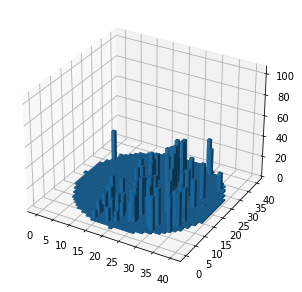

In [ ]:
voxel_im.show()

In [ ]:
# export

def VoxelBlock(cls=VoxelImage, **kwargs):
    "Block for `VoxelImage`"
    return TransformBlock(partial(cls.create, **kwargs))

In [ ]:
# export

class LasColReader(DisplayedTransform):
    "Modify `ColReader` to return coordinates from dataframe"
    def __init__(self, cols, pref='', suff='.las'):
        store_attr()
        self.pref = str(pref) + os.path.sep if isinstance(pref,Path) else pref
        self.cols = L(cols)
        
    def _do_one(self, r, c):
        "Return fname, plot_x, plot_y -tuple"
        o = r[c] if isinstance(c,int) else r[c] if c=='name' else getattr(r,c)
        if len(self.pref)==0 and len(self.suff)==0: return o
        return [f"{self.pref}{o}{self.suff}", r['x'], r['y']]
    
    def __call__(self, o, **kwargs):
        if len(self.cols) == 1: return self._do_one(o, self.cols[0])
        return L(self._do_one(o,c) for c in self.cols)

In [ ]:
df = pd.DataFrame(columns=['sampleplotid', 'x', 'y', 'v'], data=[[914153, plot_x, plot_y, 123.456]], dtype=object)
df

,sampleplotid,x,y,v
0,914153,365188,6.94385e+06,123.456


In [ ]:
test = DataBlock(blocks=(VoxelBlock, RegressionBlock),
                 get_x=LasColReader('sampleplotid', pref='data/', suff='.las'),
                 get_y=ColReader('v'),
                 splitter=None
                )
test

In [ ]:
ds = test.datasets(source=df)
ds

(#1) [(VoxelImage size=1x105x40x40, tensor(123.4560))]

<Axes3DSubplot:>

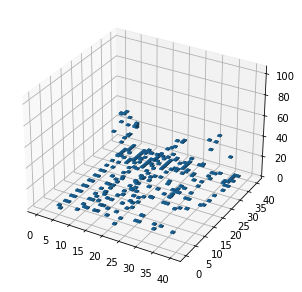

In [ ]:
ds[0][0].show()

In [ ]:
dls = test.dataloaders(source=df, bs=1)

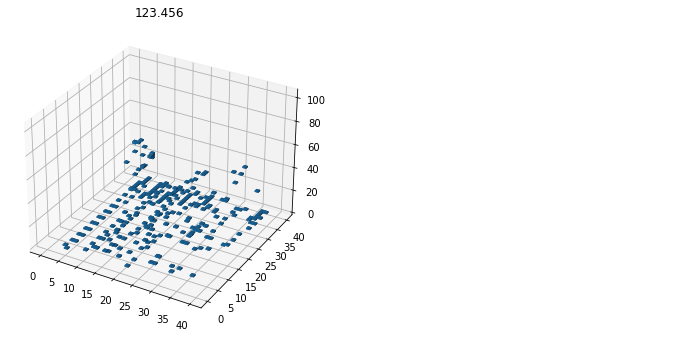

In [ ]:
dls.show_batch()

Dataloaders for `VoxelImage`

In [ ]:
# export

class VoxelDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', bin_voxels:bool=False, max_h:float=42., num_bins:int=40, num_vert_bins:int=105,
                plot_size:float=9., bottom_voxels:bool=False, mask_plot:bool=False, valid_pct=0.2, seed=None, fn_col=0,
                folder=None, suff='', label_col=1, label_delim=None, y_block=None, valid_col=None,
                item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and (len_label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        # Todo put block_kwargs to a single argument
        block_kwargs = {'bin_voxels':bin_voxels, 'max_h':max_h, 'num_bins':num_bins, 'num_vert_bins': num_vert_bins,
                        'plot_size':plot_size, 'bottom_voxels':bottom_voxels, 'mask_plot':mask_plot}
        dblock = DataBlock(blocks=(VoxelBlock(**block_kwargs), y_block),
                           #get_items=partial(get_files_from_df, extension='.las', df=df, fn_col=fn_col), 
                           #get_x=partial(get_las_files_and_voxel_kwargs, df=df,
                           #              bottom_voxels=bottom_voxels, mask_plot=mask_plot),
                           #get_y=partial(get_y_las, df=df, col=label_col),
                           get_x=LasColReader(fn_col, pref=pref, suff='.las'),
                           #get_x= lambda x:([x[fn_col], [x['x'], x['y']]]),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)
    
    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)
    
VoxelDataLoaders.from_csv = delegates(to=VoxelDataLoaders.from_df)(VoxelDataLoaders.from_csv)

In [ ]:
dls = VoxelDataLoaders.from_df(df, folder='data/', y_block=RegressionBlock,
                               label_col='v', fn_col='sampleplotid', bs=1)

In [ ]:
dls.one_batch()

(VoxelImage size=1x1x105x40x40, tensor([123.4560]))

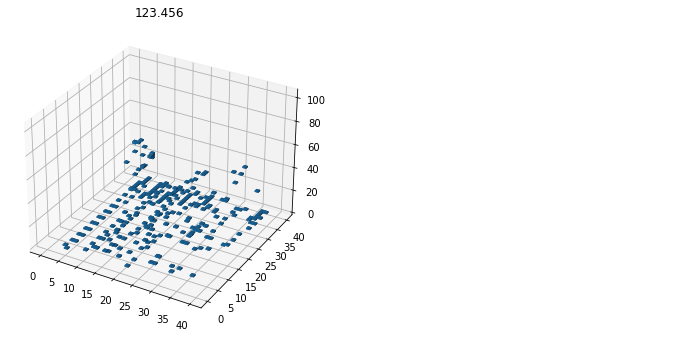

In [ ]:
dls.show_batch()

It's also possible to specify different arguments for `VoxelImage`, like `mask_plot`:

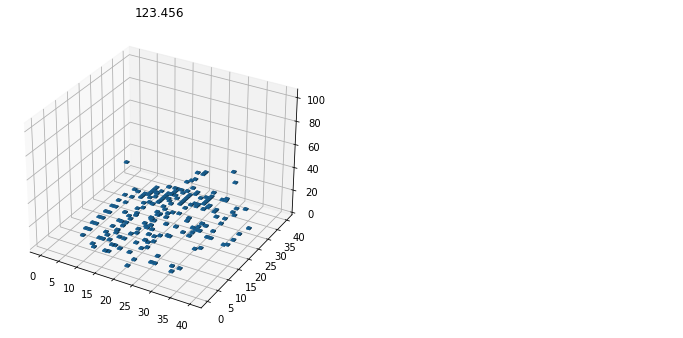

In [ ]:
dls = VoxelDataLoaders.from_df(df, folder='data/', label_col='v', 
                               fn_col='sampleplotid', bs=1, y_block=RegressionBlock,
                               mask_plot=True)
dls.show_batch()

Or `bottom_voxels`

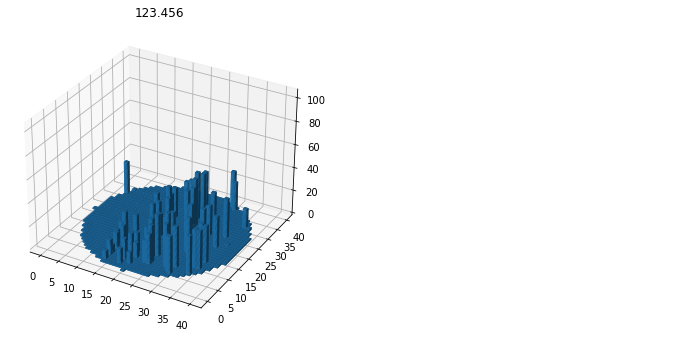

In [ ]:
dls = VoxelDataLoaders.from_df(df, folder='data/', label_col='v', 
                               fn_col='sampleplotid', bs=1,y_block=RegressionBlock,
                               mask_plot=True, bottom_voxels=True)
dls.show_batch()

In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_data.image.ipynb.
Converted 01_data.las.ipynb.
Converted 02_tabular.preprocessing.ipynb.
Converted 03_model.inception3dv3.ipynb.
Converted 04_interpretation.ipynb.
Converted 05_metrics.ipynb.
Converted 06_model.ensemble.ipynb.
Converted index.ipynb.
converting: /mnt/d/Users/E1005164/enveco/nbs/02_tabular.preprocessing.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/00_data.image.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/06_model.ensemble.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/01_data.las.ipynb
converting /mnt/d/Users/E1005164/enveco/nbs/index.ipynb to README.md
